<a href="https://colab.research.google.com/github/mhazary/git-vqa-model/blob/main/DS8013_DeepLearning_VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 10: Training Loop**

**Step 11: Saving the Model**

**Step 12: Make Predictions**

**Step 1: Mount Google Drive**

In [ ]:
# Python Code to Load and Print Dataset Information in Google Colab

import json
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
from google.colab import drive

drive.mount('/content/drive')  # Mount Google Drive to access dataset

dataset_dir = "/content/drive/MyDrive/vqa_abstract_dataset"  # Adjust this based on your Drive structure

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 2: Define Dataset Paths and Load Data**

In [ ]:
# File paths
mcq_train_file = os.path.join(dataset_dir, "vqa_v1_abstract_mcq_questions_train2015.json")
mcq_val_file = os.path.join(dataset_dir, "vqa_v1_abstract_mcq_questions_val2015.json")
annotations_train_file = os.path.join(dataset_dir, "vqa_v1_abstract_annotations_train2015.json")
annotations_val_file = os.path.join(dataset_dir, "vqa_v1_abstract_annotations_val2015.json")

In [ ]:
import os
import json

# Define the dataset directory
base_dir = "/content/drive/MyDrive/vqa_abstract_dataset"

# File paths
mcq_train_file = os.path.join(base_dir, "vqa_v1_abstract_mcq_questions_train2015.json.json")
mcq_val_file = os.path.join(base_dir, "vqa_v1_abstract_mcq_questions_val2015.json.json")
annotations_train_file = os.path.join(base_dir, "vqa_v1_abstract_annotations_train2015.json.json")
annotations_val_file = os.path.join(base_dir, "vqa_v1_abstract_annotations_val2015.json.json")

# Load multiple-choice questions
with open(mcq_train_file, "r") as f:
    mcq_train = json.load(f)

with open(mcq_val_file, "r") as f:
    mcq_val = json.load(f)

# Load annotations (answers)
with open(annotations_train_file, "r") as f:
    annotations_train = json.load(f)

with open(annotations_val_file, "r") as f:
    annotations_val = json.load(f)


In [ ]:
# Print dataset structure
print("Keys in multiple-choice questions:", mcq_train.keys())
print("\n🔹 Sample Multiple-Choice Question:")
print(json.dumps(mcq_train["questions"][0], indent=4))

print("\n🔹 Sample Answer:")
print(json.dumps(annotations_train["annotations"][0], indent=4))

Keys in multiple-choice questions: dict_keys(['info', 'task_type', 'data_type', 'license', 'questions', 'data_subtype', 'num_choices'])

🔹 Sample Multiple-Choice Question:
{
    "image_id": 11779,
    "question": "Who looks happier?",
    "multiple_choices": [
        "alive",
        "1",
        "woman",
        "purple",
        "2",
        "yes",
        "white",
        "boy",
        "she loves him",
        "mountain",
        "3",
        "no",
        "baby",
        "man",
        "yellow",
        "red",
        "4",
        "blue"
    ],
    "question_id": 117792
}

🔹 Sample Answer:
{
    "question_type": "who",
    "multiple_choice_answer": "man",
    "answers": [
        {
            "answer": "old person",
            "answer_confidence": "maybe",
            "answer_id": 1
        },
        {
            "answer": "man",
            "answer_confidence": "maybe",
            "answer_id": 2
        },
        {
            "answer": "man",
            "answer_confidenc

**Step 3: Image Transformation**

In [ ]:
# Image directory
image_dir = os.path.join(dataset_dir, "scene_img_abstract_v002_train2015")

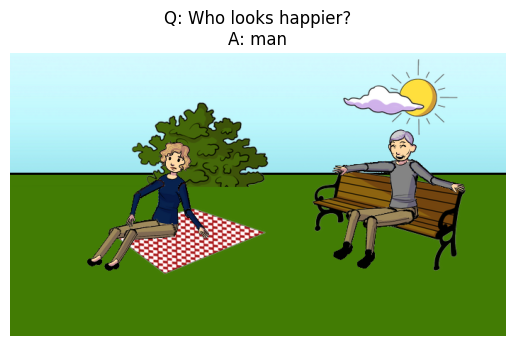

In [ ]:
# 🔹 Step 2: Display an Image with a Question & Answer


import matplotlib.pyplot as plt
from PIL import Image

# Path to image directory
image_dir = os.path.join(dataset_dir, "scene_img_abstract_v002_train2015")

# Pick a sample multiple-choice question
sample_mc_question = mcq_train["questions"][0]  # First question
sample_image_id = sample_mc_question["image_id"]

# Find the corresponding answer
sample_annotation = next(
    ann for ann in annotations_train["annotations"] if ann["image_id"] == sample_image_id
)

# Load and display image
sample_image_path = os.path.join(image_dir, f"abstract_v002_train2015_{sample_image_id:012d}.png")


if os.path.exists(sample_image_path):
    img = Image.open(sample_image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Q: {sample_mc_question['question']}\nA: {sample_annotation['multiple_choice_answer']}")
    plt.show()
else:
    print("Image not found:", sample_image_path)

In [ ]:
#  Step 1: Preprocessing Images
import torch
import torchvision.transforms as transforms
from PIL import Image

# 🔹 Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 Define ResNet-50 model and remove final classification layer
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove the final classification layer
resnet.to(device)  # Move ResNet-50 to GPU if available

# Define image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

def preprocess_image(image_path):
    """Load an image, apply transformations, and return a tensor."""
    img = Image.open(image_path).convert("RGB")  # Ensure RGB format
    img_tensor = transform(img)
    return img_tensor

# 🔹 Feature extraction function using ResNet-50
def extract_image_features(image_tensor):
    """Extract features from the image using ResNet-50."""
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():  # No need for gradients during feature extraction
        features = resnet(image_tensor)  # Features shape: [batch_size, 2048, 1, 1]
        features = features.view(features.size(0), -1)  # Flatten to [batch_size, 2048]
    return features

# Test with a sample image
sample_image_tensor = preprocess_image(sample_image_path)
print("Processed Image Shape:", sample_image_tensor.shape)  # Expected: [3, 224, 224]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


Processed Image Shape: torch.Size([3, 224, 224])


In [ ]:
import os
import torch

# Assuming preprocess_image and extract_image_features are defined elsewhere
# Example function placeholders:
def preprocess_image(image_path):
    # Replace with actual image preprocessing logic
    return torch.rand((3, 224, 224))  # Example tensor simulating an image tensor

def extract_image_features(image_tensor):
    # Replace with actual feature extraction logic
    return torch.rand((2048,))  # Example tensor simulating feature extraction

# Directory containing images
image_dir = os.path.join(dataset_dir, "scene_img_abstract_v002_train2015")

# Initialize lists to store features and image IDs
image_features_list = []
image_ids = []

# Process images in the directory
for image_name in os.listdir(image_dir):
    # Check for valid image file extensions
    if image_name.endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(image_dir, image_name)
        print(f"Processing image: {image_path}")
        try:
            # Preprocess the image
            image_tensor = preprocess_image(image_path)
            print(f"Preprocessed tensor shape: {image_tensor.shape}")

            # Extract features
            image_features = extract_image_features(image_tensor)
            print(f"Extracted features shape: {image_features.shape}")

            # Store features and image ID
            image_features_list.append(image_features)
            image_ids.append(image_name)

        except Exception as e:
            print(f"Error processing {image_name}: {e}")

# Verify and stack extracted features into a tensor
if image_features_list:
    image_features_tensor = torch.stack(image_features_list)
    print(f"Extracted Image Features Shape: {image_features_tensor.shape}")  # Should be [num_images, 2048]
else:
    print("No features were extracted. Please check preprocessing and feature extraction logic.")


Streaming output truncated to the last 5000 lines.
Extracted features shape: torch.Size([2048])
Processing image: /content/drive/MyDrive/vqa_abstract_dataset/scene_img_abstract_v002_train2015/abstract_v002_train2015_000000013227.png
Preprocessed tensor shape: torch.Size([3, 224, 224])
Extracted features shape: torch.Size([2048])
Processing image: /content/drive/MyDrive/vqa_abstract_dataset/scene_img_abstract_v002_train2015/abstract_v002_train2015_000000013226.png
Preprocessed tensor shape: torch.Size([3, 224, 224])
Extracted features shape: torch.Size([2048])
Processing image: /content/drive/MyDrive/vqa_abstract_dataset/scene_img_abstract_v002_train2015/abstract_v002_train2015_000000013223.png
Preprocessed tensor shape: torch.Size([3, 224, 224])
Extracted features shape: torch.Size([2048])
Processing image: /content/drive/MyDrive/vqa_abstract_dataset/scene_img_abstract_v002_train2015/abstract_v002_train2015_000000013228.png
Preprocessed tensor shape: torch.Size([3, 224, 224])
Extracted

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os

# 🔹 Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 Define ResNet-50 model and remove final classification layer
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove the final classification layer
resnet.to(device)  # Move ResNet-50 to GPU if available

# 🔹 Define image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

# 🔹 Preprocessing function for image
def preprocess_image(image_path):
    """Load an image, apply transformations, and return a tensor."""
    img = Image.open(image_path).convert("RGB")  # Ensure RGB format
    img_tensor = transform(img)
    return img_tensor

# 🔹 Feature extraction function using ResNet-50
def extract_image_features(image_tensor):
    """Extract features from the image using ResNet-50."""
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():  # No need for gradients during feature extraction
        features = resnet(image_tensor)  # Features shape: [batch_size, 2048, 1, 1]
        features = features.view(features.size(0), -1)  # Flatten to [batch_size, 2048]
    return features

# 🔹 Set dataset directory (adjust this as needed)
dataset_dir = "/content/drive/MyDrive/vqa_abstract_dataset"  # Adjust to your dataset directory
image_dir = os.path.join(dataset_dir, "scene_img_abstract_v002_train2015")

# 🔹 Extract features for all images in the directory
image_features_list = []
image_ids = []  # Store image IDs if needed for later use

# Check if the directory exists and contains files
if not os.path.exists(image_dir):
    print(f"Directory {image_dir} does not exist.")
else:
    image_files = os.listdir(image_dir)
    print(f"Found {len(image_files)} files in the directory.")

    for image_name in image_files:
        if image_name.endswith(".jpg"):  # Assuming the images are in .jpg format
            image_path = os.path.join(image_dir, image_name)

            try:
                # Preprocess and extract features
                image_tensor = preprocess_image(image_path)
                image_features = extract_image_features(image_tensor)

                # Store features and image ID
                image_features_list.append(image_features)
                image_ids.append(image_name)  # Or extract image ID from annotations if available
            except Exception as e:
                print(f"Error processing {image_name}: {e}")

# Check if image_features_list is not empty before stacking
if image_features_list:
    image_features_tensor = torch.stack(image_features_list)
    print(f"Extracted Image Features Shape: {image_features_tensor.shape}")  # Should be [num_images, 2048]
else:
    print("No image features extracted.")


Found 20084 files in the directory.
No image features extracted.


**Step 4: Text Tokenization Using BERT**

In [ ]:
from transformers import BertTokenizer

# 🔹 Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def preprocess_question(question, max_length=30):
    """Tokenizes a question and returns input tensors on GPU."""
    encoded = tokenizer(
        question,
        padding="max_length",
        max_length=max_length,  # Dynamic max_length
        truncation=True,
        return_tensors="pt"
    )

    input_ids = encoded["input_ids"].squeeze(0).to(device)  # Shape: [seq_len]
    attention_mask = encoded["attention_mask"].squeeze(0).to(device)  # Shape: [seq_len]

    return input_ids, attention_mask

# 🔹 Test with Sample Data (Question)
sample_question = "What is the person holding?"
input_ids, attention_mask = preprocess_question(sample_question)

print("Tokenized Question:", input_ids)
print("Attention Mask:", attention_mask)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenized Question: tensor([ 101, 2054, 2003, 1996, 2711, 3173, 1029,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])


**Step 5: Answer Encoding**

In [ ]:
#🔹 Step 3: Preprocessing Answers

# Python Code for Answer Encoding

# Collect all unique answers to create a vocabulary
all_answers = [ann["multiple_choice_answer"] for ann in annotations_train["annotations"]]
answer_vocab = {ans: idx for idx, ans in enumerate(set(all_answers))}  # Create dictionary

def preprocess_answer(answer):
    """Converts an answer into a numerical label."""
    return answer_vocab.get(answer, -1)  # Return -1 if the answer is not found in vocab

# Test with a sample answer
sample_answer = annotations_train["annotations"][0]["multiple_choice_answer"]
answer_label = preprocess_answer(sample_answer)

print("Answer:", sample_answer)
print("Encoded Answer Label:", answer_label)


Answer: man
Encoded Answer Label: 1530


**Step 6: Dataset Creation (VQADataset)**

In [ ]:
# 🔹 Step 4: Creating the Final Dataset
# Python Code to Create the Final Dataset
from torch.utils.data import Dataset, DataLoader

class VQADataset(Dataset):
    def __init__(self, questions, annotations, image_dir):
        self.questions = questions["questions"]
        self.annotations = annotations["annotations"]
        self.image_dir = image_dir

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        # Get question and answer
        question_text = self.questions[idx]["question"]
        answer_text = self.annotations[idx]["multiple_choice_answer"]

        # Get image ID and load image
        image_id = self.questions[idx]["image_id"]
        image_path = os.path.join(self.image_dir, f"abstract_v002_train2015_{image_id:012d}.png")

        # Preprocess image, question, and answer
        image_tensor = preprocess_image(image_path)
        input_ids, attention_mask = preprocess_question(question_text)
        answer_label = preprocess_answer(answer_text)

        return image_tensor, input_ids, attention_mask, answer_label



**Step 7: DataLoader Preparation**

In [ ]:
# Initialize dataset
vqa_dataset = VQADataset(mcq_train, annotations_train, image_dir)

# Create DataLoader
dataloader = DataLoader(vqa_dataset, batch_size=16, shuffle=True)

# Test a batch
batch = next(iter(dataloader))
print("Batch Image Shape:", batch[0].shape)  # Expected: [batch_size, 3, 224, 224]
print("Batch Question Shape:", batch[1].shape)  # Expected: [batch_size, 20]
print("Batch Answer Shape:", batch[3].shape)  # Expected: [batch_size]

Batch Image Shape: torch.Size([16, 3, 224, 224])
Batch Question Shape: torch.Size([16, 30])
Batch Answer Shape: torch.Size([16])


**Step 8: Define VQA Model (CNN + LSTM)**

In [ ]:
import torch.nn as nn
import torchvision.models as models
class VQAModel(nn.Module):
    def __init__(self, vocab_size, answer_size, embed_dim=300, hidden_dim=512):
        super(VQAModel, self).__init__()

        # 🔹 IMAGE FEATURE EXTRACTOR (ResNet-50)
        resnet = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])  # Remove final classification layer
        self.image_fc = nn.Linear(2048, hidden_dim)  # Reduce feature size

        # 🔹 TEXT FEATURE EXTRACTOR (LSTM)
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Word Embeddings
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        # 🔹 FUSION & CLASSIFICATION
        self.fc1 = nn.Linear(hidden_dim * 2, 512)  # Merge Image + Text Features
        self.fc2 = nn.Linear(512, answer_size)  # Final Classification Layer

    def forward(self, images, questions):
        # 🔹 IMAGE FEATURES
        image_features = self.cnn(images)  # Output: [batch, 2048, 1, 1]
        image_features = image_features.view(image_features.size(0), -1)  # Flatten: [batch, 2048]
        image_features = self.image_fc(image_features)  # Reduce to [batch, hidden_dim]

        # 🔹 TEXT FEATURES
        # Ensure questions are in the correct format [batch_size, seq_len]
        embedded = self.embedding(questions)  # [batch, seq_len, embed_dim]

        # If necessary, squeeze any extra dimension from the input
        embedded = embedded.squeeze(1)  # This may be unnecessary if shape is already correct, but just in case

        # Get the last hidden state from LSTM
        _, (hidden, _) = self.lstm(embedded)  # Get last LSTM hidden state [batch, hidden_dim]
        text_features = hidden[-1]  # Extract final hidden state

        # 🔹 MERGE IMAGE + TEXT
        combined = torch.cat((image_features, text_features), dim=1)  # [batch, hidden_dim * 2]
        x = torch.relu(self.fc1(combined))
        output = self.fc2(x)  # Output logits [batch, answer_size]

        return output


**Step 9: Model, Criterion, and Optimizer**

In [ ]:
import torch.optim as optim

# Initialize the model, loss function, and optimizer
vocab_size = 30522  # BERT tokenizer vocab size
answer_size = len(answer_vocab)  # Number of unique answers
model = VQAModel(vocab_size, answer_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
!pip install --upgrade torch torch_xla


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:

# Load the dataset
with open(mcq_train_file, "r") as f:
    mcq_train = json.load(f)

with open(mcq_val_file, "r") as f:
    mcq_val = json.load(f)

with open(annotations_train_file, "r") as f:
    annotations_train = json.load(f)

with open(annotations_val_file, "r") as f:
    annotations_val = json.load(f)

# Print dataset structure
print("Keys in multiple-choice questions:", mcq_train.keys())
print("\n🔹 Sample Multiple-Choice Question:")
print(json.dumps(mcq_train["questions"][0], indent=4))

print("\n🔹 Sample Answer:")
print(json.dumps(annotations_train["annotations"][0], indent=4))

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def preprocess_image(image_path):
    """Load an image, apply transformations, and return a tensor."""
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img)
    return img_tensor

# Text tokenization and encoding using BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def preprocess_question(question):
    """Tokenizes and converts a question into a numerical tensor."""
    encoded_question = tokenizer(question, padding="max_length", max_length=20, truncation=True, return_tensors="pt")
    return encoded_question["input_ids"], encoded_question["attention_mask"]

# Answer encoding
all_answers = [ann["multiple_choice_answer"] for ann in annotations_train["annotations"]]
answer_vocab = {ans: idx for idx, ans in enumerate(set(all_answers))}

def preprocess_answer(answer):
    """Converts an answer into a numerical label."""
    return answer_vocab.get(answer, -1)  # Return -1 if the answer is not found in vocab

# Dataset creation
class VQADataset(Dataset):
    def __init__(self, questions, annotations, image_dir):
        self.questions = questions["questions"]
        self.annotations = annotations["annotations"]
        self.image_dir = image_dir

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question_text = self.questions[idx]["question"]
        answer_text = self.annotations[idx]["multiple_choice_answer"]
        image_id = self.questions[idx]["image_id"]
        image_path = os.path.join(self.image_dir, f"abstract_v002_train2015_{image_id:012d}.png")

        image_tensor = preprocess_image(image_path)
        input_ids, attention_mask = preprocess_question(question_text)
        answer_label = preprocess_answer(answer_text)

        return image_tensor, input_ids, attention_mask, answer_label

# Prepare DataLoader
image_dir = os.path.join(dataset_dir, "scene_img_abstract_v002_train2015")
vqa_dataset = VQADataset(mcq_train, annotations_train, image_dir)
dataloader = DataLoader(vqa_dataset, batch_size=16, shuffle=True)

# Define the VQA Model (CNN + LSTM)
class VQAModel(nn.Module):
    def __init__(self, vocab_size, answer_size, embed_dim=300, hidden_dim=512):
        super(VQAModel, self).__init__()

        resnet = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])  # Remove final classification layer
        self.image_fc = nn.Linear(2048, hidden_dim)  # Reduce feature size

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Word Embeddings
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim * 2, 512)  # Merge Image + Text Features
        self.fc2 = nn.Linear(512, answer_size)  # Final Classification Layer

    def forward(self, images, questions):
        image_features = self.cnn(images)  # Output: [batch, 2048, 1, 1]
        image_features = image_features.view(image_features.size(0), -1)  # Flatten: [batch, 2048]
        image_features = self.image_fc(image_features)  # Reduce to [batch, hidden_dim]

        embedded = self.embedding(questions)  # [batch, seq_len, embed_dim]
        _, (hidden, _) = self.lstm(embedded)  # Get last LSTM hidden state [batch, hidden_dim]
        text_features = hidden[-1]  # Extract final hidden state

        combined = torch.cat((image_features, text_features), dim=1)  # [batch, hidden_dim * 2]
        x = torch.relu(self.fc1(combined))
        output = self.fc2(x)  # Output logits [batch, answer_size]

        return output

# Model, criterion, and optimizer
vocab_size = 30522  # BERT tokenizer vocab size
answer_size = len(answer_vocab)  # Number of unique answers
model = VQAModel(vocab_size, answer_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    for images, input_ids, attention_mask, labels in dataloader:
        images, input_ids, labels = images.to(device), input_ids.squeeze(1).to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids)  # Forward pass

        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")

# Test the model
def predict(image_path, question_text):
    image_tensor = preprocess_image(image_path).unsqueeze(0).to(device)
    input_ids, _ = preprocess_question(question_text)
    input_ids = input_ids.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor, input_ids)
        predicted_label = torch.argmax(F.softmax(output, dim=1), dim=1).item()

    predicted_answer = [key for key, val in answer_vocab.items() if val == predicted_label][0]
    return predicted_answer

# Example
test_image = "/content/drive/MyDrive/vqa_abstract_dataset/scene_img_abstract_v002_train2015/abstract_v002_train2015_000000000144.png"
test_question = "What is the man holding?"

predicted_answer = predict(test_image, test_question)
print("Predicted Answer:", predicted_answer)


Keys in multiple-choice questions: dict_keys(['info', 'task_type', 'data_type', 'license', 'questions', 'data_subtype', 'num_choices'])

🔹 Sample Multiple-Choice Question:
{
    "image_id": 11779,
    "question": "Who looks happier?",
    "multiple_choices": [
        "alive",
        "1",
        "woman",
        "purple",
        "2",
        "yes",
        "white",
        "boy",
        "she loves him",
        "mountain",
        "3",
        "no",
        "baby",
        "man",
        "yellow",
        "red",
        "4",
        "blue"
    ],
    "question_id": 117792
}

🔹 Sample Answer:
{
    "question_type": "who",
    "multiple_choice_answer": "man",
    "answers": [
        {
            "answer": "old person",
            "answer_confidence": "maybe",
            "answer_id": 1
        },
        {
            "answer": "man",
            "answer_confidence": "maybe",
            "answer_id": 2
        },
        {
            "answer": "man",
            "answer_confidenc

In [ ]:
!nvidia-smi


In [ ]:
import torch

# Define the model saving path
checkpoint_path = "/content/drive/MyDrive/vqa_abstract_dataset/vqa_model.pth"

# Inside the training loop
for epoch in range(num_epochs):
    total_loss = 0

    for images, input_ids, attention_mask, labels in dataloader:
        images, input_ids, labels = images.to(device), input_ids.squeeze(1).to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids)  # Forward pass

        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()

        total_loss += loss.item()

    # Print loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")

    # Save the model after every epoch
    torch.save(model.state_dict(), checkpoint_path)

print("Model saved at:", checkpoint_path)


In [ ]:
model.load_state_dict(torch.load(checkpoint_path))

In [ ]:

for epoch in range(num_epochs):
    print(f"Starting Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for batch_idx, (images, input_ids, attention_mask, labels) in enumerate(dataloader):
        if batch_idx % 10 == 0:  # Print every 10th batch to monitor progress
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(dataloader)}")

        images, input_ids, labels = images.to(device), input_ids.squeeze(1).to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images, input_ids)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backpropagation
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss/len(dataloader):.4f}")
